# Dask Delayed

## Notebook Objectives
* **Recap Delayed API** from first course.
* **Parallelize Python code with Delayed API**.
* **Best Practices** for using Dask Delayed.
* **References** for further reading.

## Recap basics of Delayed API

We introduced the Dask Dealayed API in the first course:
* It can be used to parallelize regular Python code.
* It is evaluated lazily, meaning computation isn't evaluated until necessary, or until we call `compute()`.
* The task graph generated can be visualized using `visualize`.

In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [2]:
from dask import delayed

x = delayed(inc)(10)
y = delayed(inc)(10)

z = delayed(add)(x, y)
z

Delayed('add-6aae8eb9-1fa2-4af7-af1e-0b71f22ff8a6')

In [3]:
z.compute()

22

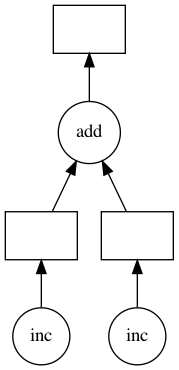

In [4]:
z.visualize()

## Parallize Python code with Delayed

We will look at more examples of using Delayed in this section.

### Parallel for-loop

Loops are the most common parts of a program that can be parallelized. Let's take a look at the following sequential for-loop.

In [5]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
%%time

results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
total

CPU times: user 948 µs, sys: 1.19 ms, total: 2.14 ms
Wall time: 8.03 s


44

It can be parallelized by wrapping certain functions with delayed.

In [7]:
%%time

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
total

CPU times: user 2.09 ms, sys: 944 µs, total: 3.03 ms
Wall time: 2.43 ms


Delayed('sum-fec9e99c-c860-4e82-8ac7-1707b89370c2')

In [8]:
%%time
total.compute()

CPU times: user 2.94 ms, sys: 1.87 ms, total: 4.82 ms
Wall time: 1.01 s


44

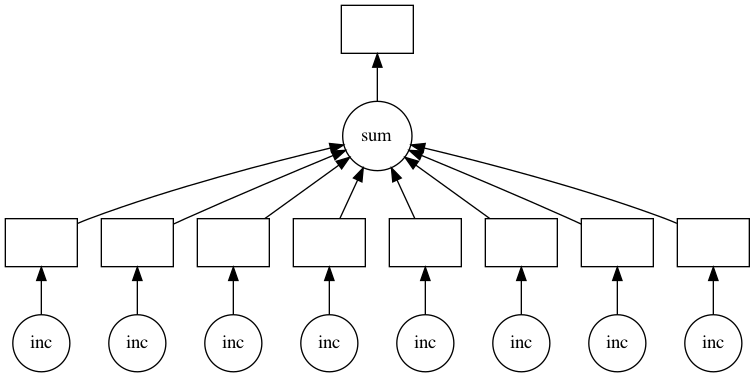

In [9]:
total.visualize()

Notice that the computation is significantly faster!

### Parallel Pandas `groupby()`

For another example, let's go back to the NYC taxi cabs dataset. Again, we assume all csv files are in the `/data` subdirectory.

In [ ]:
# Uncomment to download data again
# !wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-{01..12}.csv

Similar to the computation in the DataFrame notebook, we read the data for one month and find the mean tip amount as a function of passenger count.

In [13]:
import pandas as pd

df = pd.read_csv("data/yellow_tripdata_2019-01.csv")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [14]:
df.groupby("passenger_count").tip_amount.mean()

passenger_count
0    1.786901
1    1.828308
2    1.833877
3    1.795579
4    1.702710
5    1.869868
6    1.856830
7    6.542632
8    6.480690
9    3.116667
Name: tip_amount, dtype: float64

Now, to compute this value across the entire dataset, we can use the following sequential code:

In [15]:
import os
from glob import glob

filenames = sorted(glob(os.path.join('data', '*.csv')))

In [16]:
%%time

sums = []
counts = []

for fn in filenames:
    # Read file
    df = pd.read_csv(fn)

    # Groupby passenger_count
    by_passenger_count = df.groupby('passenger_count')

    # Sum of (all) tip_amount as function of passenger_count
    amount = by_passenger_count.tip_amount.sum()

    # Number of total data points
    total = by_passenger_count.tip_amount.count()

    # Save the intermediates
    sums.append(amount)
    counts.append(total)

# Combine intermediates to get total mean
sum_tip_amount = sum(sums)
n_passengers = sum(counts)
mean = sum_tip_amount / n_passengers
mean

<decorator-gen-54>:2: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 2min 20s, sys: 17.4 s, total: 2min 37s
Wall time: 2min 38s


passenger_count
0    2.122789
1    2.206790
2    2.214306
3    2.137775
4    2.023804
5    2.235441
6    2.221105
7    6.675962
8    7.111625
9    7.377822
Name: tip_amount, dtype: float64

Parallelize using delayed:

In [17]:
from dask import compute

In [18]:
%%time

sums = []
counts = []

for fn in filenames:
    
    df = delayed(pd.read_csv)(fn)  # Delayed!

    by_passenger_count = df.groupby('passenger_count')
 
    amount = by_passenger_count.tip_amount.sum()

    total = by_passenger_count.tip_amount.count()

    sums.append(amount)
    counts.append(total)

    
sums, counts = compute(sums, counts)  # Compute the intermediates!
    
sum_tip_amount = sum(sums)
n_passengers = sum(counts)
mean = sum_tip_amount / n_passengers
mean

/Users/pavithra-coiled/.conda/envs/talkpython-dask/lib/python3.8/site-packages/dask/local.py:237: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  return [execute_task(*a) for a in it]


CPU times: user 3min 42s, sys: 1min 36s, total: 5min 18s
Wall time: 2min


passenger_count
0    2.122789
1    2.206790
2    2.214306
3    2.137775
4    2.023804
5    2.235441
6    2.221105
7    6.675962
8    7.111625
9    7.377822
Name: tip_amount, dtype: float64

## Checkpoint

**Question:** Using the Delayed API to parallelize, create a NumPy array `x` of any size and compute the sum of all array entires.

In [ ]:
# Your answer here

In [ ]:
import numpy as np

x = delayed(np.ones)((1000,1000), dtype=int)
y = x.sum()
y.compute()

## Best Practices

1. Delayed is called on Python functions and not the results

In [ ]:
# [DON'T] Call delayed on result, becasuse it executes immediately

dask.delayed(f(x, y))

In [ ]:
# [DO] Call delayed on function

dask.delayed(f)(x, y)

2. Compute at once, instead of repeatedly

In [ ]:
# [DON'T] Call compute repeatedly

results = []
for x in L:
    y = dask.delayed(f)(x)
    results.append(y.compute())

results

In [ ]:
# [DO] Collect many calls for one compute

results = []
for x in L:
    y = dask.delayed(f)(x)
    results.append(y)

results = dask.compute(*results)

3. Do not change (mutate) inputs

In [ ]:
# [Don'T] Mutate inputs in functions

@dask.delayed
def f(x):
    x += 1
    return x

In [ ]:
# [DO] Return new values or copies

@dask.delayed
def f(x):
    x = x + 1
    return x

For more best practices, refer to the [Dask documentation](https://docs.dask.org/en/latest/delayed-best-practices.html).

## References

* [Dask Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Dask Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)
* [Dask Tutorial - Delayed](https://tutorial.dask.org/01_dask.delayed.html)